## Time Series Analysis of Electricity Production

In [2]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Loading the Data

In [4]:
col_names = ["date","value"]
df = pd.read_csv("Electric_Production.csv", names=col_names, header=0)

In [5]:
df.head()

,date,value
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [9]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)
df = df.set_index(['date'])

In [11]:
df.head()

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### Rolling Statistics

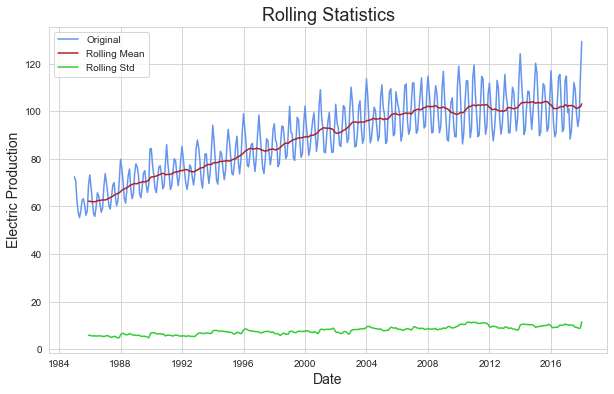

In [33]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()

plt.figure(figsize=(10,6))

plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')

plt.xlabel('Date', size=14)
plt.ylabel('Electric Production', size=14)

plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size=18)

plt.show()

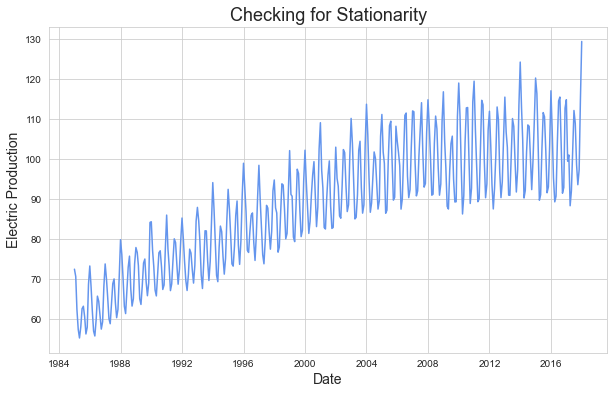

In [37]:
plt.figure(figsize=(10,6))
plt.plot(df['value'], color='cornflowerblue')

plt.title('Checking for Stationarity', size=18)
plt.xlabel('Date', size = 14)
plt.ylabel('Electric Production', size=14)

plt.show()

Looking at the plot we can observe there is an **upward trend** over the period of time

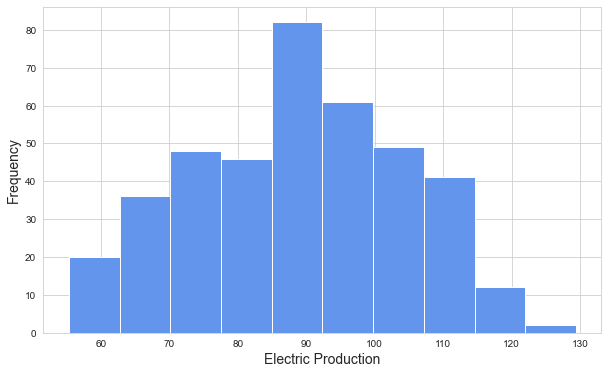

In [39]:
plt.figure(figsize=(10,6))
plt.hist(df['value'], color='cornflowerblue')

plt.xlabel('Electric Production', size=14)
plt.ylabel('Frequency', size=14)

plt.show()

In [41]:
print("Data shape: {}".format(df.shape))

value_1 = df[0:199]
value_2 = df[200:397]

Data shape: (397, 1)


We will proceed by splitting the data into two parts so that we can then check the **mean** and **variance** of the data.

### Mean Of Data

In [43]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))

Mean of value_1: 77.497


In [44]:
print("Mean of value_2: {}".format(round(value_1.mean()[0],3)))

Mean of value_2: 77.497


### Variance of Data

In [45]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))

Variance of value_1: 123.226


In [46]:
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_2: 91.677


### Augmented Dickey-Fuller Test

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

**Null Hypothesis**: Time Series is non-stationary. It gives a time-dependent trend.

**Alternate Hypothesis**: Time Series is stationary. In another term, the series doesn’t depend on time.

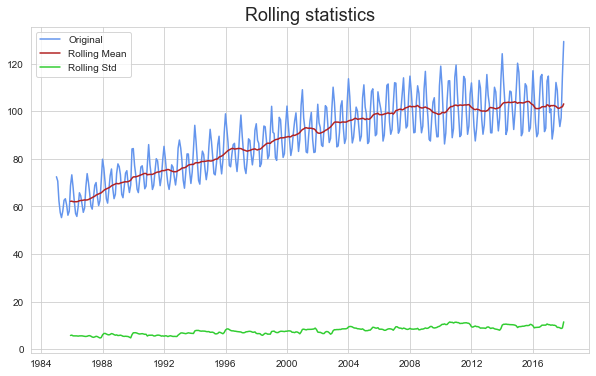

ADF Statistics: -2.257
p-value: 0.186
Critical Values: 
1% : -3.448
5% : -2.869
10% : -2.571
ADF < Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [55]:
def adfuller_test(ts, window=12):
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize=(10,6))
    original = plt.plot(ts, color='cornflowerblue', label='Original')
    
    mean = plt.plot(movingAverage, color='firebrick', label='Rolling Mean')
    
    std = plt.plot(movingSTD, color='limegreen', label='Rolling Std')
    
    plt.legend(loc = 'upper left')
    plt.title('Rolling statistics', size=18)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag = 'AIC')

    print('ADF Statistics: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print('Critical Values: ')
    for key, ts in adf[4].items():
        print('{} : {}'.format(key, round(ts,3)))
        
    if adf[0] > adf[4]["5%"]:
        print("ADF < Critical Values")
        print("Failed to reject null hypothesis, time series is non-stationary.")
        
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window=12)

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

### Transforming the data

#### 1. Logarithmic Transformation

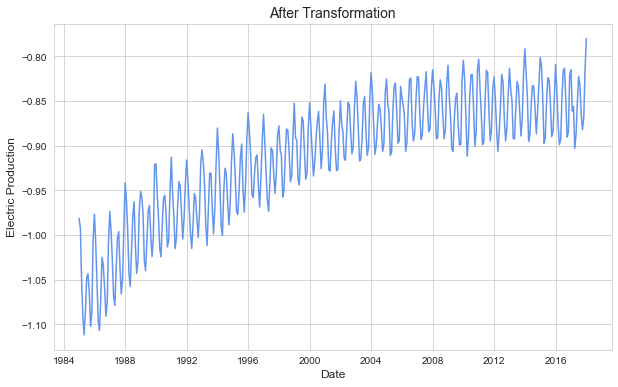

In [60]:
df_log_scaled = df

df_log_scaled['value'] = boxcox(df_log_scaled['value'], lmbda=0.0)

plt.figure(figsize=(10,6))
plt.plot(df_log_scaled, color='cornflowerblue')
plt.xlabel('Date', size=12)
plt.ylabel('Electric Production', size=12)
plt.title("After Transformation", size=14)
plt.show()

#### 2. Removing Trend With Moving Average

A time series with a trend is called non-stationary.

An identified trend can be modeled. Once modeled, it can be removed from the time series dataset. This is called detrending the time series.

If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.

In [62]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg

In [65]:
df_log_scaled_ma.dropna(inplace=True)

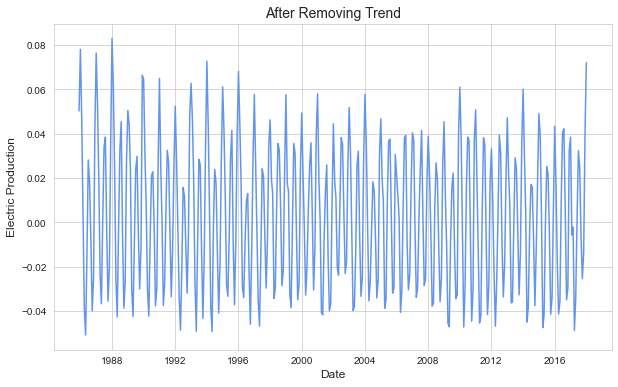

In [69]:
plt.figure(figsize=(10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Removing Trend", size = 14)
plt.show()

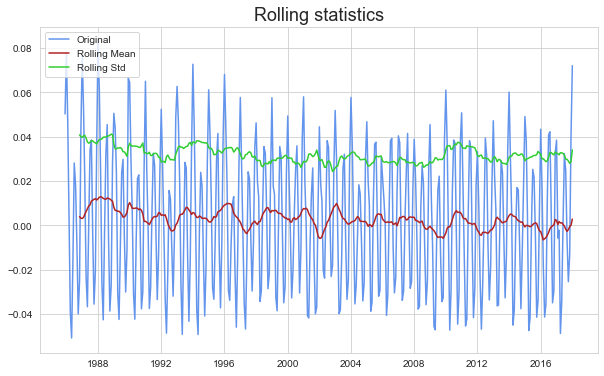

ADF Statistics: -4.783
p-value: 0.0
Critical Values: 
1% : -3.448
5% : -2.869
10% : -2.571
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [70]:
adfuller_test(df_log_scaled_ma, window=12)

### Decomposition

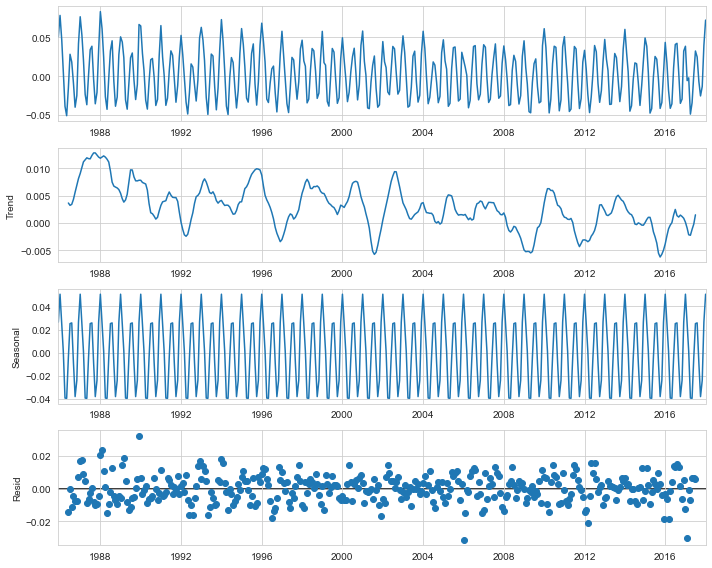

In [71]:
rcParams['figure.figsize'] = 10,8
df_seasonal_decompose = seasonal_decompose(df_log_scaled_ma, model = 'duplicative')

df_seasonal_decompose.plot()
plt.show()

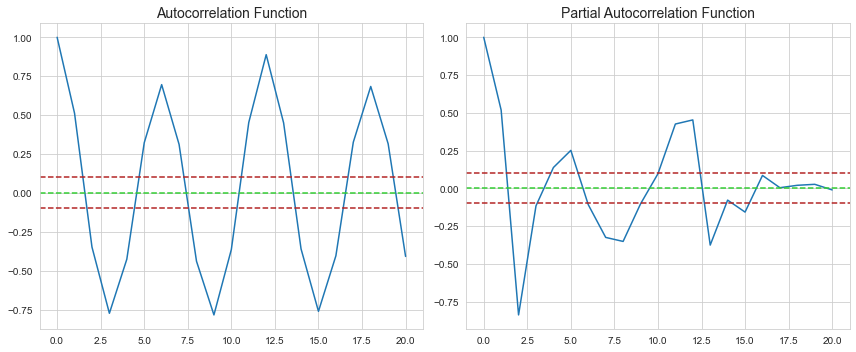

In [78]:
### ACF and PACF plots

auto_c_f = acf(df_log_scaled_ma, nlags=20)
partial_auto_c_f = pacf(df_log_scaled_ma, nlags=20, method='ols')

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_log_scaled_ma)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_log_scaled_ma)),
            linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)     


plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_log_scaled_ma)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_log_scaled_ma)),
            linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)
            
plt.tight_layout() 


### Autoregression model

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class.

In [80]:
vals = df_log_scaled_ma.values
train = vals[1:len(vals)-10]
test = vals[len(vals)-10:]

model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, predictions)

print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0024


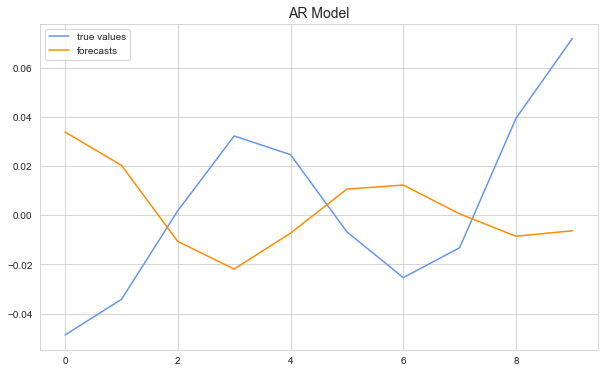

In [81]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

### Moving Average Model

In [82]:
model = ARIMA(train, order=(0,1,2))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.0016


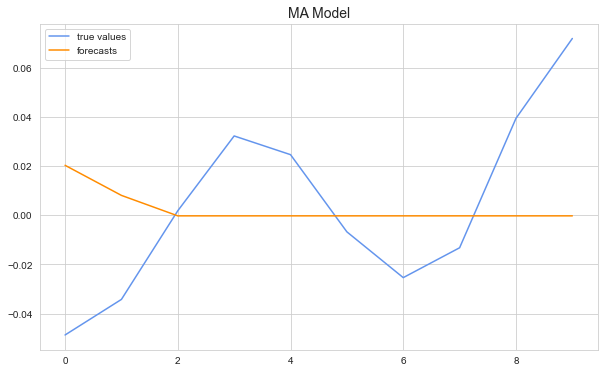

In [83]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

### ARIMA Model

In [85]:
model = ARIMA(train, order=(2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score,4)))

ARIMA MSE: 0.0009


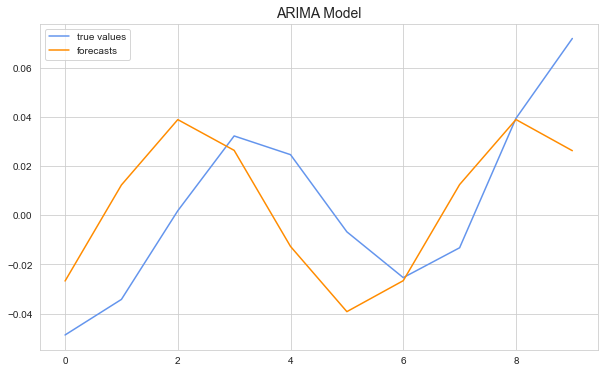

In [86]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()